# Test des fonctions de sauvegarde et de chargement

Ce script marche pour les machines sans CPU, celui dans [Main](AutoEncodeur_notebook.ipynb), marche pour les machines à GPU


In [1]:
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt

tensor_transform = transforms.ToTensor()



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class AutoEncodeur(torch.nn.Module):
    def __init__(self): 
        super().__init__()

        #Création de l'encodeur
        self.encodeur = torch.nn.Sequential(
            #Linear(entré, sortie) -> matrice entré x sortie
            torch.nn.Linear(3*400 * 400,1000), # La taille de la couche
            torch.nn.ReLU(), # La fonction d'activation
            torch.nn.Linear(1000, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 50)
        )


        self.decodeur = torch.nn.Sequential(
            torch.nn.Linear(50, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 1000),
            torch.nn.ReLU(),
            torch.nn.Linear(1000, 3*400*400),
            torch.nn.Sigmoid() #Sigmoid à la fin pour avori une valeur entre 0 et 1
        )


    def forward(self, x):
        # Aplatir l'entrée (x est de forme [batch_size, 3, 400, 400])
        x = x.view(x.size(0), -1)  # Aplatissement : [batch_size, 3*400*400]
        
        encoded = self.encodeur(x)  # Passer par l'encodeur
        decoded = self.decodeur(encoded)  # Passer par le décodeur
        
        # Reformater la sortie pour avoir la forme [batch_size, 3, 400, 400]
        decoded = decoded.view(x.size(0), 3, 400, 400)  # Reshape en image
        
        return decoded


class AutoEncodeurConv(torch.nn.Module):
    def __init__(self):
        super().__init__()

        #Création de l'encodeur
        self.encodeur = torch.nn.Sequential(
            torch.nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),  # (3, 400, 400) -> (16, 200, 200)
            torch.nn.ReLU(),
            torch.nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # (16, 200, 200) -> (32, 100, 100)
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # (32, 100, 100) -> (64, 50, 50)
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # (64, 50, 50) -> (128, 25, 25)
            torch.nn.ReLU(),

        )
        # Ajout de quelques couches linéaires
        self.fc_encodeur = torch.nn.Linear(128 * 25 * 25, 512)  # Réduction de dimension avant le décodage
        self.fc_decodeur = torch.nn.Linear(512, 128 * 25 * 25) 

        # Décodeur
        self.decodeur = torch.nn.Sequential(
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # (128, 25, 25) -> (64, 50, 50)
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # (64, 50, 50) -> (32, 100, 100)
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # (32, 100, 100) -> (16, 200, 200)
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),  # (16, 200, 200) -> (3, 400, 400)
            torch.nn.Sigmoid()
        )


    def forward(self, x): # Le feedForward -> propagation avant
        encoded = self.encodeur(x)

        encoded = encoded.view(encoded.size(0), -1)  # Aplatir le tenseur pour la couche linéaire
        encoded = self.fc_encodeur(encoded)

        # Passer par la couche linéaire inverse dans le décodeur
        decoded = self.fc_decodeur(encoded)

        # Reshaping pour correspondre aux dimensions de l'image
        decoded = decoded.view(decoded.size(0), 128, 25, 25)

        decoded = self.decodeur(decoded)
        return decoded





In [3]:
model = AutoEncodeurConv().to(device)
fonction_perte = torch.nn.MSELoss()
#fonction_perte = torch.nn.BCELoss()

#lr : learning rate 
optimizer = torch.optim.Adam(model.parameters(),lr = 1e-4, weight_decay=1e-8)

In [8]:
import torch

def save(fileName = "model_weights.pth"): # Cette fonction sauvegarde le modèle.
    torch.save(model.state_dict(), fileName) # Sauvegarde le model

def load(fileName = "model_weights.pth"): # Cette fonction permet de charger le modèle à partir d'un fichier
    
    #model.load_state_dict(torch.load(fileName)) # charge le model
    state_dict = torch.load(fileName, map_location=torch.device('cpu'))
    model.load_state_dict(state_dict)
    model.eval()  # Définir le modèle en mode évaluation (important pour certaines couches comme Dropout)

load()


In [26]:
import os
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt


class CustomImageTestDataset(Dataset):
    def __init__(self, image_dir, transform=None):

        self.image_dir = image_dir
        self.transform = transform
        self.image_paths = [ os.path.join(root, fname) for root, dirs, files in os.walk(image_dir)  for fname in files if fname.endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)


        label = 'good' if img_path.split("\\")[-2] == 'good' else 'anomalie'
        

        return image,label


transform = transforms.Compose([
    transforms.ToTensor()           
])

# Chemin vers le répertoire contenant les images de test
image_dir = 'engine_wiring/engine_wiring/test'

# Créer une instance du dataset
datasetTest = CustomImageTestDataset(image_dir=image_dir, transform=transform)



# Créer un DataLoader pour itérer sur le dataset
test_loader = DataLoader(datasetTest, batch_size=1, shuffle=True)



In [36]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

def evaluate_autoencoder(model, test_loader, device):
    model.eval()  # Passer le modèle en mode évaluation
    total_loss = 0
    num_samples = 0

    result = {'good':[],'anomalie':[]}

    with torch.no_grad():  # Désactiver le calcul des gradients
        for data in test_loader:
            inputs, label = data  

            inputs = inputs.to(device)

            outputs = model(inputs)
            
            # Calcul de la perte L2 (Mean Squared Error)
            loss = F.mse_loss(outputs, inputs, reduction='sum') 
            result[label[0]].append(loss.item())
            total_loss += loss.item()
            num_samples += inputs.size(0)

    # Moyenne de la perte sur tout le dataset de test
    avg_loss = total_loss / num_samples
    result = {"good":np.array(result["good"])/num_samples,"anomalie":np.array(result["anomalie"])/num_samples}
    return avg_loss,result


avg,re = evaluate_autoencoder(model, test_loader, device)



In [28]:
print(re)

{'good': [5564.22900390625, 7966.947265625, 4899.9345703125, 7564.9130859375, 10047.2626953125, 5798.4091796875, 7425.3515625, 510.9905090332031, 726.4912109375, 620.3155517578125, 7023.63232421875, 554.5223388671875, 7389.609375, 7330.140625, 6881.013671875, 6379.19677734375, 9509.1328125, 570.7767333984375, 522.3284912109375, 7093.412109375, 8817.5224609375, 511.715576171875, 8783.5244140625, 5902.1708984375, 6958.296875, 612.8408203125, 10273.2353515625, 8280.923828125, 7067.46728515625, 7605.32177734375, 7824.798828125, 15850.20703125, 9780.080078125, 626.9089965820312, 6187.48486328125, 8174.849609375, 587.8716430664062, 9529.40625, 6432.3046875, 5500.46875, 6525.81201171875, 8899.6123046875, 9259.3251953125, 8505.349609375, 6067.02880859375, 784.6483764648438, 7446.984375, 7000.73828125, 8381.84375, 654.3936767578125, 476.4850769042969, 6296.33154296875, 8816.6416015625, 718.7721557617188, 8075.27001953125, 7267.267578125, 727.6266479492188, 6386.0166015625, 5247.3662109375, 1014

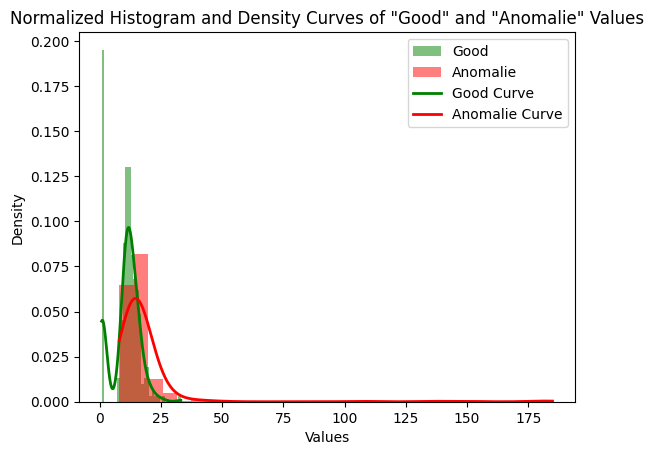

10.520676653675752
32.77888767043443
17.767530264673848
318.7516340846228


In [38]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

good_values = re['good']
anomalie_values = re['anomalie']

# Création de l'histogramme normalisé
plt.hist(good_values, bins=30, alpha=0.5, label='Good', color='g', density=True)
plt.hist(anomalie_values, bins=30, alpha=0.5, label='Anomalie', color='r', density=True)

#Création de la courbe pour les "bonnes" images
kde_good = gaussian_kde(good_values)
x_good = np.linspace(min(good_values), max(good_values), 1000)
plt.plot(x_good, kde_good(x_good), color='g', label='Good Curve', lw=2)

# Pareil pour anomalie
kde_anomalie = gaussian_kde(anomalie_values)
x_anomalie = np.linspace(min(anomalie_values), max(anomalie_values), 1000)
plt.plot(x_anomalie, kde_anomalie(x_anomalie), color='r', label='Anomalie Curve', lw=2)

plt.title('Normalized Histogram and Density Curves of "Good" and "Anomalie" Values')
plt.xlabel('Values')
plt.ylabel('Density')

plt.legend()

#plt.xlim(0, 50000)


#plt.xscale('log')

plt.show()


print(np.mean(good_values))
print(np.var(good_values))
print(np.mean(anomalie_values))
print(np.var(anomalie_values))
